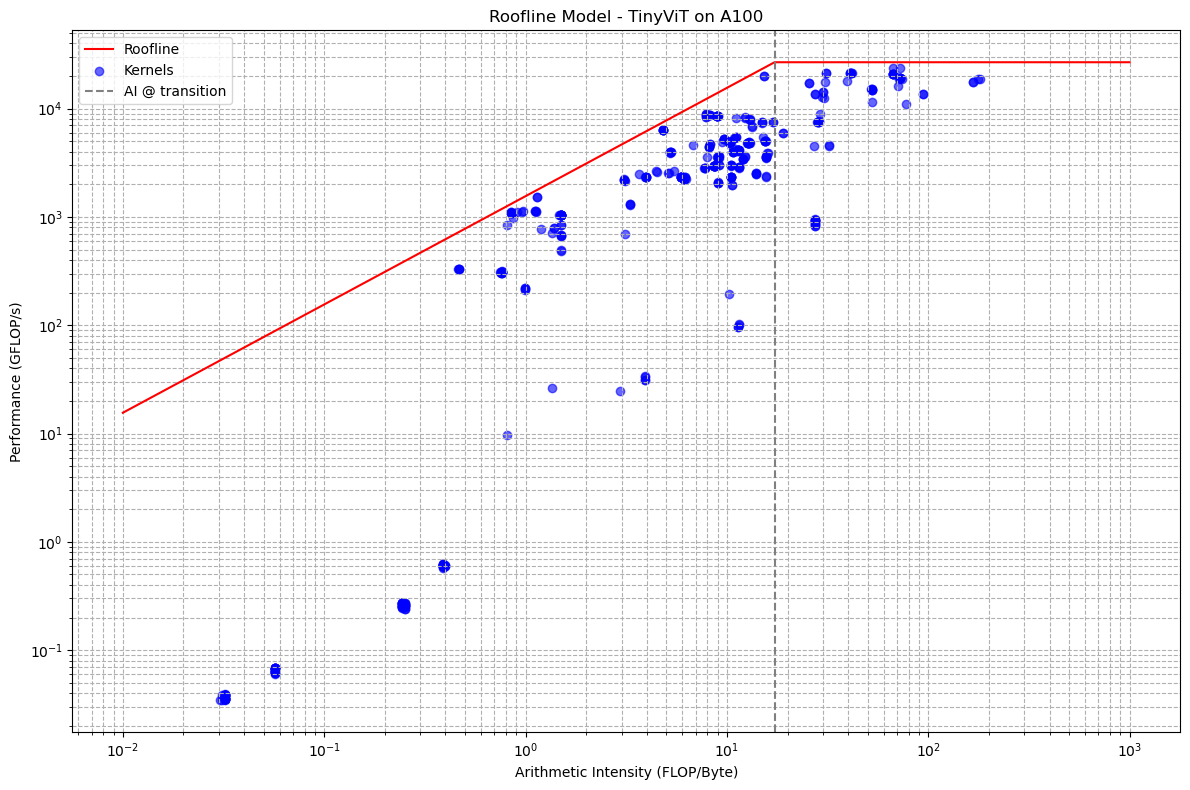


Top 3 kernels with highest Arithmetic Intensity (AI):

ampere_fp16_s16816gemm_fp16_128x128_ldg8_relu_f2f_...
  AI        : 180.52 FLOP/Byte
  GFLOP/s   : 18586.13

ampere_fp16_s16816gemm_fp16_128x128_ldg8_relu_f2f_...
  AI        : 176.40 FLOP/Byte
  GFLOP/s   : 18631.95

ampere_fp16_s16816gemm_fp16_128x128_ldg8_relu_f2f_...
  AI        : 167.15 FLOP/Byte
  GFLOP/s   : 17545.55



In [5]:
# Roofline Model - TinyViT on A100

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV and clean
df = pd.read_csv("tinyvit-a100.csv", skiprows=9)
df = df.iloc[1:].copy()

# Convert to numeric
df["gpu__time_duration.sum"] = pd.to_numeric(df["gpu__time_duration.sum"], errors="coerce")
df["dram__bytes_read.sum"] = pd.to_numeric(df["dram__bytes_read.sum"], errors="coerce")
df["dram__bytes_write.sum"] = pd.to_numeric(df["dram__bytes_write.sum"], errors="coerce")
df["fadd"] = pd.to_numeric(df["smsp__sass_thread_inst_executed_op_fadd_pred_on.sum"], errors="coerce")
df["fmul"] = pd.to_numeric(df["smsp__sass_thread_inst_executed_op_fmul_pred_on.sum"], errors="coerce")
df["ffma"] = pd.to_numeric(df["smsp__sass_thread_inst_executed_op_ffma_pred_on.sum"], errors="coerce")
df["fp16"] = pd.to_numeric(df["smsp__sass_thread_inst_executed_op_fp16_pred_on.sum"], errors="coerce")
df["tensor"] = pd.to_numeric(df["sm__inst_executed_pipe_tensor.sum"], errors="coerce")

# Compute metrics
df["FLOPs"] = (
    df["fadd"] +
    df["fmul"] +
    2 * df["ffma"] +
    2 * df["fp16"] +
    512 * df["tensor"]
)
df["Bytes"] = df["dram__bytes_read.sum"] + df["dram__bytes_write.sum"]
df["AI"] = df["FLOPs"] / df["Bytes"]
df = df.dropna(subset=["AI", "FLOPs", "Bytes", "gpu__time_duration.sum"])
df = df[(df["FLOPs"] > 0) & (df["gpu__time_duration.sum"] > 0)]
df["GFLOP/s"] = df["FLOPs"] / (df["gpu__time_duration.sum"] * 1e-9) / 1e9

# A100 spec
peak_bandwidth = 1555  # GB/s
peak_flops = min(df["GFLOP/s"].max() * 1.12, 156000)  # GFLOP/s

# Roofline curve
ai_range = np.logspace(-2, 3, 500)
roofline = np.minimum(ai_range * peak_bandwidth, peak_flops)

# Plot
plt.figure(figsize=(12, 8))
plt.loglog(ai_range, roofline, label="Roofline", color="red")
plt.scatter(df["AI"], df["GFLOP/s"], label="Kernels", color="blue", alpha=0.6)

# Add transition line
transition_ai = peak_flops / peak_bandwidth
plt.axvline(transition_ai, color='gray', linestyle='--', label="AI @ transition")

# Format plot
plt.xlabel("Arithmetic Intensity (FLOP/Byte)")
plt.ylabel("Performance (GFLOP/s)")
plt.title("Roofline Model - TinyViT on A100")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# Top 3 kernels with highest Arithmetic Intensity (AI)
top_kernels = df.sort_values("AI", ascending=False).head(3)
top_kernels_info = top_kernels[["Kernel Name", "AI", "GFLOP/s"]]
print("\nTop 3 kernels with highest Arithmetic Intensity (AI):\n")
for i, row in top_kernels_info.iterrows():
    print(f"{row['Kernel Name'][:50]}...\n"
          f"  AI        : {row['AI']:.2f} FLOP/Byte\n"
          f"  GFLOP/s   : {row['GFLOP/s']:.2f}\n")
